# 표준화 진행 후 독립변수를 다항식으로 변환한 결과

## #01. 패키지

In [1]:
import sys
sys.path.append('../../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures    #다항식 변환 모듈

## #02. 데이터 준비

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #03.~#04. 생략

## #05. 데이터셋 분할

### 랜덤시드 고정

In [3]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [4]:
origin.columns

Index(['길이', '높이', '두께', '무게'], dtype='object')

In [5]:
x = origin[['길이', '높이', '두께']]
y = origin[['무게']]
# (행 수, 열 수)
x.shape, y.shape

((56, 3), (56, 1))

### 데이터 표준화

차후 학습 결과 적용에서 스케일링 데이터를 사용해야하기 때문에 독립/종속 변수를 따로 스케일링
- 통계에서는 종속변수 표준화를 권장하지 않음
- 예측 값을 역 표준화 해야하지 때문
- 단, 머신러닝 선능을 위해서 종속변수 표준화 권장

- 표준화를 거치면 numpy 배열 형태(2차원 데이터 배열) -> [0]로 열 길이 출력 가능
- 표준화를 진행하지 않으면 DF 형태(1차원 형태) -> iloc[0]로 열 길이 출력 가능
- type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [6]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

# y_scaller = StandardScaler()
# y_scale = y_scaller.fit_transform(y)

# x_scale.shape, y_scale.shape
x_scale.shape

(56, 3)

In [7]:
print(type(x_scale), type(y))

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [8]:
x_scale_df = DataFrame(x_scale, columns=['길이','높이','두께'])
x_scale_df.head()

,길이,높이,두께
0,-2.180225,-2.016507,-1.896175
1,-1.587434,-1.518703,-1.560774
2,-1.442032,-1.417039,-1.316328
3,-1.307815,-1.147103,-1.202633
4,-1.173599,-1.147103,-1.026405


### 독립변수를 다항식으로 변환

`PolynomialFeatures클래스를 사용`하여 $y = ax + b$ 라는 회귀식을 $y = ax^2 + bx + c$ 형태로 바꾼다.

- degree : 변환할 차수 (기본값=2)
    - 1 : [a,b] = $ax+b$, 2 : [a,b,c] = $ax^2+bx+c$, 3 : [a,b,c,d] = $ax^3+bx^2+cx+d$
- include_bias : True인 경우 0차항(1)도 함께 생성한다. (기본값=True) 
    - 0차항은 유효한 값은 아님.

In [9]:
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x_scale_df)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479
1,-1.587434,-1.518703,-1.560774,2.519946,2.410841,2.477625,2.306460,2.370352,2.436014
2,-1.442032,-1.417039,-1.316328,2.079457,2.043416,1.898188,2.008000,1.865289,1.732721
3,-1.307815,-1.147103,-1.202633,1.710381,1.500199,1.572822,1.315845,1.379544,1.446326
4,-1.173599,-1.147103,-1.026405,1.377334,1.346238,1.204588,1.315845,1.177393,1.053508


### 훈련 데이터와 검증 데이터로 분할

In [10]:
# 종속변수 y는 표준화 미진행 -> y사용
x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 9), (17, 9), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

- input_shape은 독립변수 수
- Dense 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [11]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train.iloc[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [12]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500


2/2 [==============================] - 2s 240ms/step - loss: 282850.0000 - mae: 395.1754 - val_loss: 221118.7656 - val_mae: 350.6720 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 35ms/step - loss: 282649.9062 - mae: 395.0061 - val_loss: 220956.1250 - val_mae: 350.5330 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 74ms/step - loss: 282445.7188 - mae: 394.8339 - val_loss: 220803.5469 - val_mae: 350.4010 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 68ms/step - loss: 282266.2188 - mae: 394.6721 - val_loss: 220644.2812 - val_mae: 350.2657 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 54ms/step - loss: 282084.3750 - mae: 394.5093 - val_loss: 220482.0625 - val_mae: 350.1300 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 65ms/step - loss: 281878.4688 - mae: 394.3462 - val_loss: 220316.6250 - val_mae: 349.9925 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 67ms/step - los

## #07. 학습 결과 평가

- 학습결과 시각화
- 손실률, 절대오차 그래프
- 손실률, 절대오차 텍스트

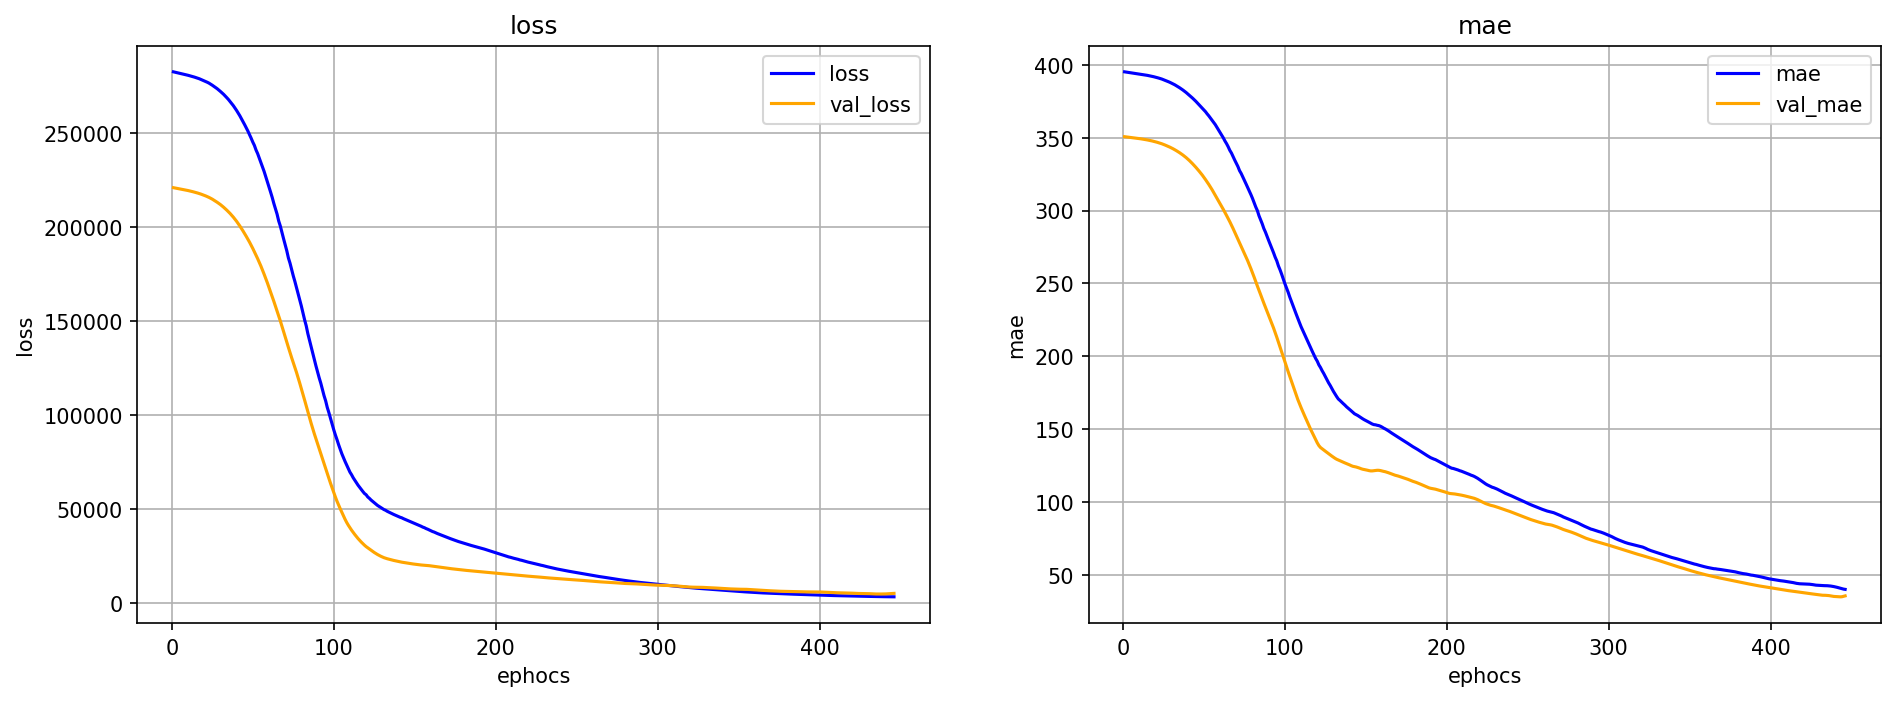

2/2 [==============================] - 0s 4ms/step - loss: 3091.4839 - mae: 39.9051
최종 훈련 손실률: 3091.483887, 최종 훈련 절대오차: 39.905136
1/1 [==============================] - 0s 26ms/step - loss: 4935.9814 - mae: 35.6444
최종 검증 손실률: 4935.981445, 최종 검증 절대오차: 35.644436


In [13]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [14]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 21ms/step


### 결과 데이터 셋 구성

In [15]:
x2.columns

Index(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께', '두께^2'], dtype='object')

In [16]:
train_df = DataFrame(x_train, columns=x2.columns)
train_df['무게(관측치)'] = y_train['무게'].values
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
8,-0.927534,-0.954292,-0.969558,0.860320,0.885138,0.899298,0.910672,0.925241,0.940042,85.0,103.439934,-18.439934
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479,5.9,119.148163,-113.248163
15,-0.659101,-0.779008,-0.696689,0.434414,0.513445,0.459188,0.606854,0.542726,0.485375,120.0,132.993515,-12.993515
26,-0.368297,-0.396891,-0.327179,0.135643,0.146174,0.120499,0.157523,0.129854,0.107046,188.0,157.794495,30.205505
51,1.577847,1.731046,1.207709,2.489601,2.731326,1.905580,2.996521,2.090600,1.458561,1100.0,1011.142639,88.857361


In [17]:
test_df = DataFrame(x_test, columns=x2.columns)
test_df['무게(관측치)'] = y_test['무게'].values
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차(잔차)'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
16,-0.659101,-0.614242,-0.696689,0.434414,0.404847,0.459188,0.377294,0.427936,0.485375,130.0,136.928146,-6.928146
12,-0.770948,-0.761480,-0.611417,0.594361,0.587062,0.471371,0.579852,0.465582,0.373831,125.0,125.267693,-0.267693
21,-0.580807,-0.670333,-0.634156,0.337337,0.389334,0.368323,0.449346,0.425096,0.402154,145.0,140.788620,4.211380
33,-0.043940,-0.204080,-0.099788,0.001931,0.008967,0.004385,0.041649,0.020365,0.009958,250.0,205.378067,44.621933
36,0.235678,-0.084887,0.013907,0.055544,-0.020006,0.003278,0.007206,-0.001181,0.000193,320.0,240.089600,79.910400


### 실제 결과값과 머신러닝에 의한 예측값 비교

In [18]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

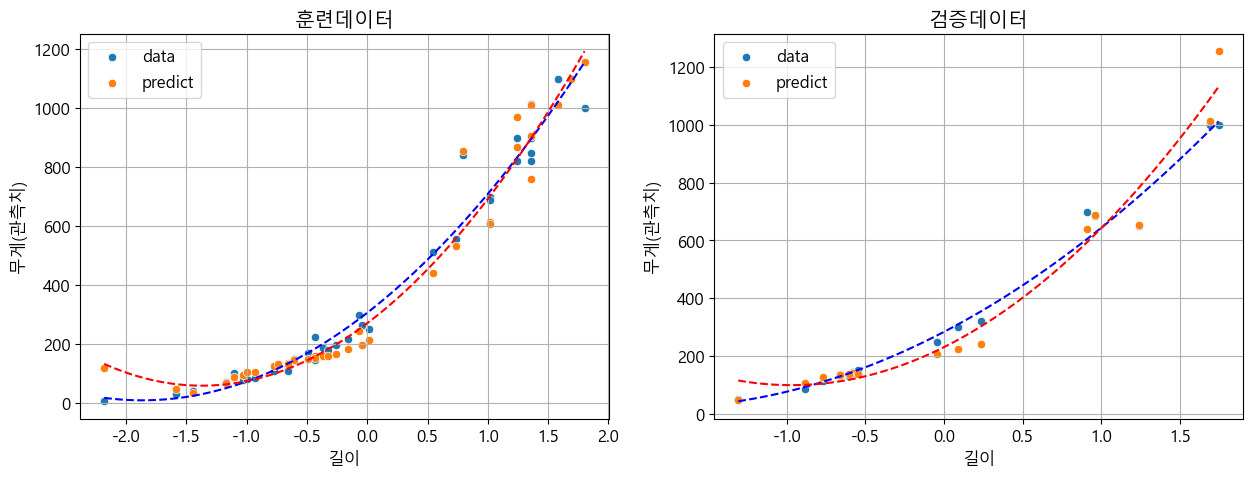

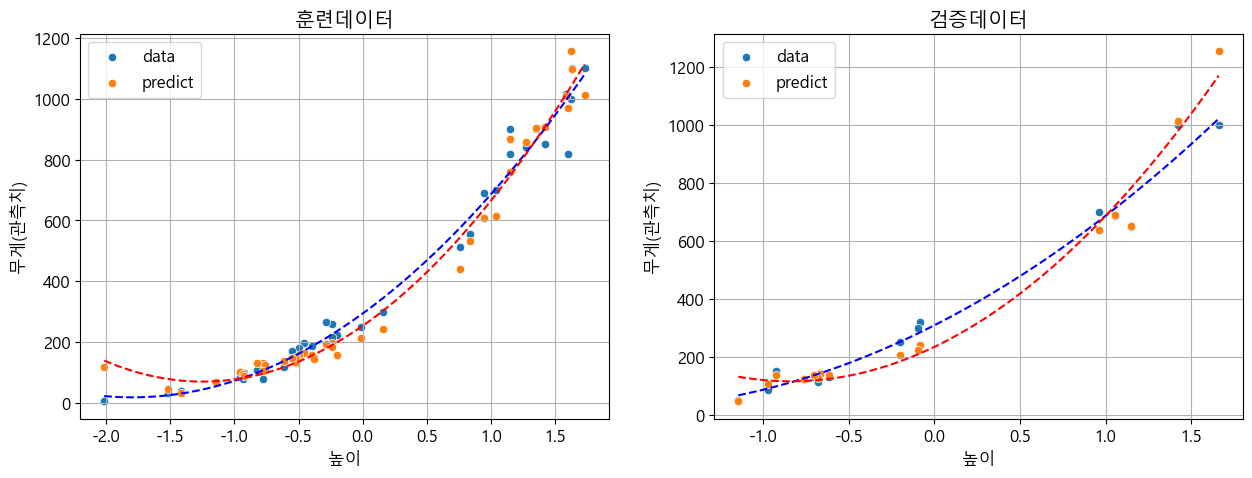

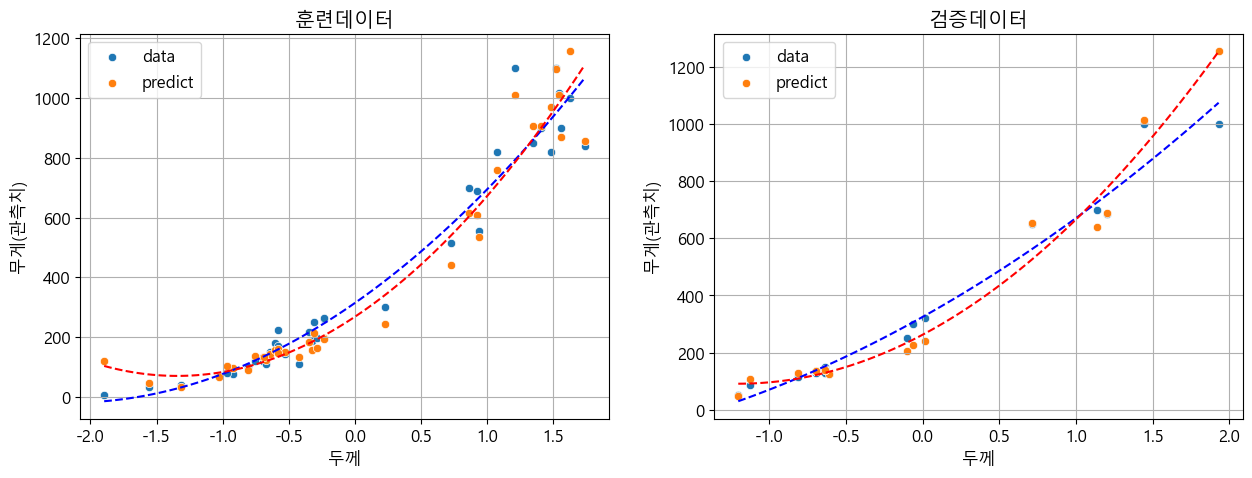

In [19]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))